# **ASAH (Aplikasi Sortir Sampah)**

Ini merupakan repository untuk pembuatan model machine learning klasifikasi gambar sampah untuk proyek akhir Bangkit Academy 2023.

# **Install Tensorflow**

In [9]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Tensorflow JS**

In [10]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import Library**

Diperlukan import library berikut untuk mengerjakan proyek ini.

In [11]:
import os
import shutil
import zipfile
import pathlib
import random

import cv2

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import plot_model

print('setup successful')

setup successful


##**Cek versi library**

In [12]:
print(f'Tensorflow version: {tf.__version__}')
print(f'OpenCV version: {cv2.__version__}')
print(f'Numpy version: {np.__version__}')

Tensorflow version: 2.12.0
OpenCV version: 4.7.0
Numpy version: 1.22.4


# **Dataset Preparation**

Dataset yang digunakan adalah dataset Garbage Classification yang memuat 12 jenis sampah. Dataset ini diperoleh dari kaggle dengan link: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code

In [13]:
! pip install -q kaggle

##**Setup Kaggle**

In [14]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"{your_username}","key":"{your_api_key}"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


##**Download Dataset**

In [15]:
!kaggle datasets download mostafaabla/garbage-classification

 99% 237M/239M [00:01<00:00, 163MB/s]
100% 239M/239M [00:01<00:00, 166MB/s]


## **Extraction**

In [16]:
local_zip = 'garbage-classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [17]:
PATH = '/content/garbage_classification'

# **Explore Dataset**

Menggabungkan beberapa kelas, diantaranya: 'brown-glass'; 'green-glass'; 'white-glass' menjadi sebuah kelas bernama 'gelas'

In [18]:
old_PATH = '/content/garbage_classification'
new_PATH = '/content/garbage_classification_merged'  # New path

old_data_dir = pathlib.Path(old_PATH)
new_data_dir = pathlib.Path(new_PATH)  # New data directory

os.makedirs(new_data_dir, exist_ok=True)

# Initialize counts
glass_count = 0
class_labels = []
class_counts = []

for original_label in os.listdir(old_data_dir):
    old_label_dir = os.path.join(old_data_dir, original_label)
    count_label_dir = len(os.listdir(old_label_dir))
    new_label_dir = os.path.join(new_data_dir, original_label)
    if 'glass' in original_label:
        new_label_dir = os.path.join(new_data_dir, 'glass')
        if 'glass' not in class_labels:
            class_labels.append('glass')
            class_counts.append(0)
        glass_count += count_label_dir
        class_counts[class_labels.index('glass')] = glass_count
    else:
        class_labels.append(original_label)
        class_counts.append(count_label_dir)

    os.makedirs(new_label_dir, exist_ok=True)

    for file_name in os.listdir(old_label_dir):
        shutil.move(os.path.join(old_label_dir, file_name), new_label_dir)


## **Visualisasi Data**


Distribution of Images in the new location:
1. shoes : 1977
2. glass : 2011
3. metal : 769
4. cardboard : 891
5. biological : 985
6. paper : 1050
7. battery : 945
8. plastic : 865
9. trash : 697
10. clothes : 5325

Total images from this dataset: 15515





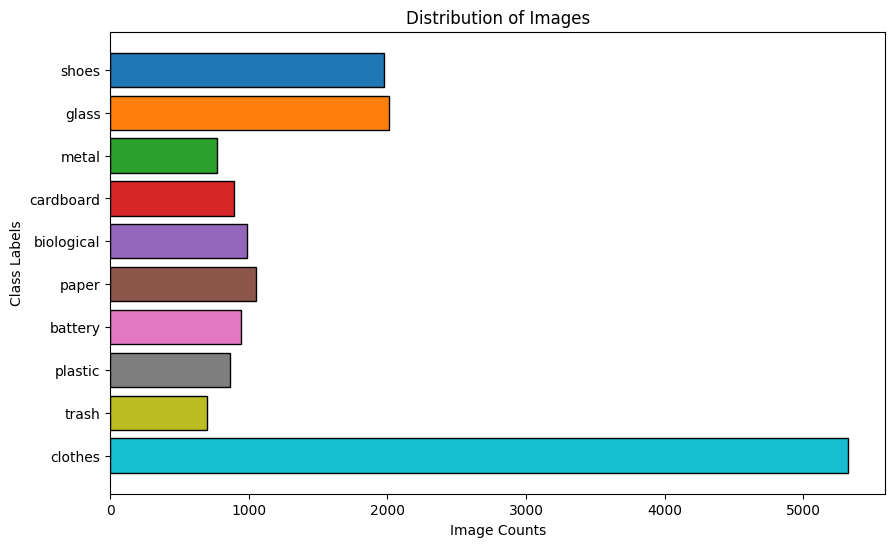

In [19]:
import matplotlib.colors as mcolors

new_class_labels = []
new_class_counts = []

print('\nDistribution of Images in the new location:')
for i, label in enumerate(os.listdir(new_data_dir)):
    label_dir = os.path.join(new_data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')
    new_class_labels.append(label)
    new_class_counts.append(len_label_dir)

# Check total in new directory
image_count = len(list(new_data_dir.glob('*/*.jpg')))
print(f'\nTotal images from this dataset: {image_count}')

print('\n\n')
# Create color mapping for each class
colors = [mcolors.TABLEAU_COLORS[key] for key in mcolors.TABLEAU_COLORS.keys()]

plt.figure(figsize=(10,6))
plt.barh(new_class_labels, new_class_counts, color=colors, edgecolor='black')
plt.xlabel('Image Counts')
plt.ylabel('Class Labels')
plt.title('Distribution of Images')
plt.gca().invert_yaxis()  # Invert y-axis for a better visual effect
plt.show()

## **Garbage Variant**

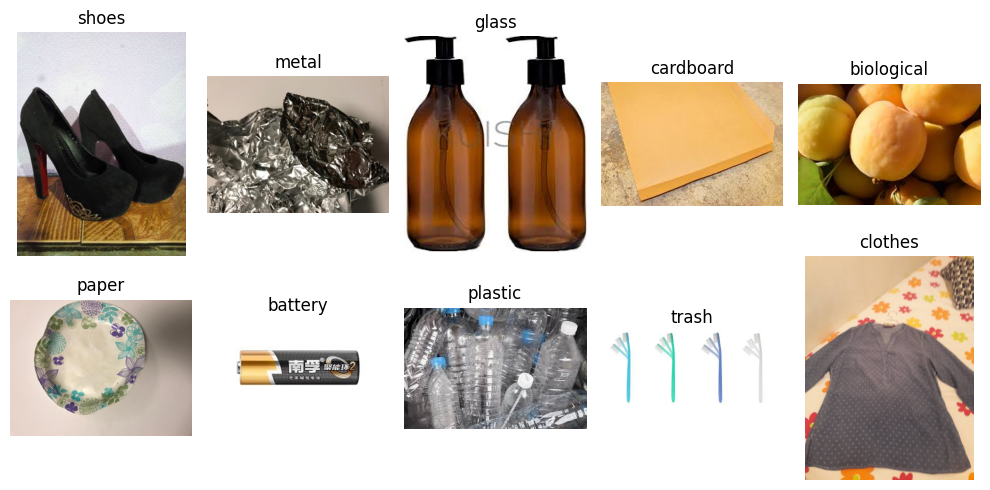

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i, label in enumerate(class_labels):
    label_dir = os.path.join(new_data_dir, label)
    image_files = os.listdir(label_dir)
    random_image_file = random.choice(image_files)
    image_path = os.path.join(label_dir, random_image_file)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# **Remove Broken Files**

In [21]:
def verify_images(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') or filename.endswith('.bmp'):
                try:
                    file_path = os.path.join(folder_path, filename)
                    img = tf.io.read_file(file_path)
                    img = tf.image.decode_jpeg(img, channels=3)
                except tf.errors.InvalidArgumentError:
                    print('Deleting bad file:', file_path) # print out the names of corrupt files
                    os.remove(file_path) # delete the problematic file

In [22]:
verify_images(new_data_dir)

# **Data Preprocessing & Transformation**

## **Set Up Parameter**


Cell berikut ini menyiapkan beberapa konstanta dan nilai awal yang akan digunakan dalam kode berikutnya.

**BATCH_SIZE = 32:** Menentukan ukuran batch yang akan digunakan saat melatih model. Batch adalah jumlah sampel data yang diproses sebelum model diperbarui. Ukuran batch yang lebih besar memerlukan lebih banyak memori, tetapi dapat melatih model lebih cepat.

**IMG_SIZE = (224, 224):** Menentukan ukuran gambar yang akan digunakan. Dalam hal ini, semua gambar akan diubah ukurannya menjadi 224x224 piksel.

**np.random.seed(123):** Mengatur nilai seed (nilai awal) untuk generator angka acak di NumPy. Ini memastikan bahwa hasil dari fungsi random yang dipanggil berikutnya dapat direproduksi.

**seed = np.random.randint(0,100):** Menghasilkan angka acak antara 0 dan 100 menggunakan fungsi randint dari NumPy. Angka acak ini akan digunakan sebagai nilai seed dalam fungsi berikutnya.

print(f"Current seed : {seed}"): Menampilkan angka acak yang telah dihasilkan.

In [23]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

np.random.seed(123)
seed = np.random.randint(0,100)
print(f"Current seed : {seed}")

Current seed : 66


## **Divide Data into Train and Validation Test**

Proses selanjutnya adalah pembagian Dataset. Dataset akan dibagi menjadi train dan validation test. Data train atau latih akan digunakan untuk membangun model, sedangkan data validation dan test akan digunakan untuk menguji performa model. Pada proyek ini dataset sebesar 15.515 data gambar akan dibagi menjadi 80% (Train Set Data) dan 20% (Validation Set Data).

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  new_data_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  new_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 15515 files belonging to 10 classes.
Using 12412 files for training.
Found 15515 files belonging to 10 classes.
Using 3103 files for validation.


In [25]:
class_names = train_ds.class_names
class_names_val = val_ds.class_names

## **Test Data**

Membagi validation set data untuk menghasilkan test data

In [26]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 78
Number of test batches: 19


**Data Performance**

Bagian kode ini berfungsi untuk mengoptimalkan performa loading data pada saat proses training.

**AUTOTUNE =** tf.data.AUTOTUNE: Mendefinisikan variabel AUTOTUNE yang akan digunakan oleh TensorFlow untuk secara otomatis menentukan jumlah buffer yang akan digunakan dalam proses prefetch.

**train_ds =** train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE): Kode ini mengambil dataset training (train_ds), menyimpannya dalam cache (untuk meningkatkan kecepatan loading data), mengacak data (dengan jumlah data sebanyak seperempat dari total gambar), dan melakukan prefetching (untuk mempersiapkan data pada batch selanjutnya sebelum batch saat ini selesai diproses).

**val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE):** Sama seperti sebelumnya, namun pada dataset validasi, dan tidak melakukan proses shuffle.

**test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE):** Melakukan prefetching pada dataset testing, untuk mempersiapkan data pada batch selanjutnya sebelum batch saat ini selesai diproses.

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(image_count//4).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Build a Model**



kode ini akan membantu dalam meningkatkan variasi dari data yang dimiliki sehingga model dapat belajar dari berbagai perubahan dan modifikasi pada gambar.

**tf.keras.layers.RandomFlip('horizontal_and_vertical'):** Layer ini akan melakukan flip secara acak pada gambar baik secara horizontal maupun vertikal.

**tf.keras.layers.RandomRotation(0.2):** Layer ini akan melakukan rotasi acak pada gambar dengan maksimal 20% dari pi radian.

**tf.keras.layers.RandomZoom(0.1):** Layer ini akan melakukan zoom acak pada gambar dengan faktor zoom maksimal sebesar 10%.

In [28]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1)],
  name="data_augmentation")

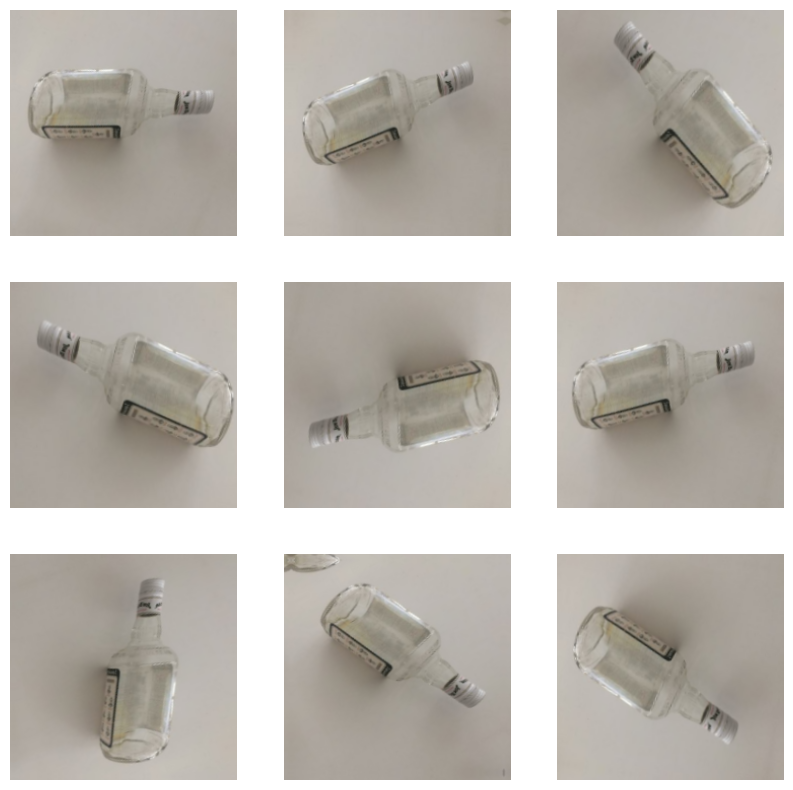

In [29]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [30]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

9406464/9406464 [==============================] - 0s 0us/step


In [31]:
def model_builder():
  num_classes = len(class_names)

  model = tf.keras.Sequential()

  model.add(inputs)
  model.add(data_augmentation)
  model.add(normalization_layer)
  model.add(base_model)
  model.add(global_average_layer)

  model.add(tf.keras.layers.Dense(units=512, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(num_classes,
                                  activation='softmax',
                                  name="final_output"))

  base_learning_rate = 1e-3
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  return model

In [32]:
model = model_builder()

## **Model Summary**

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                        

## **Plot Model**

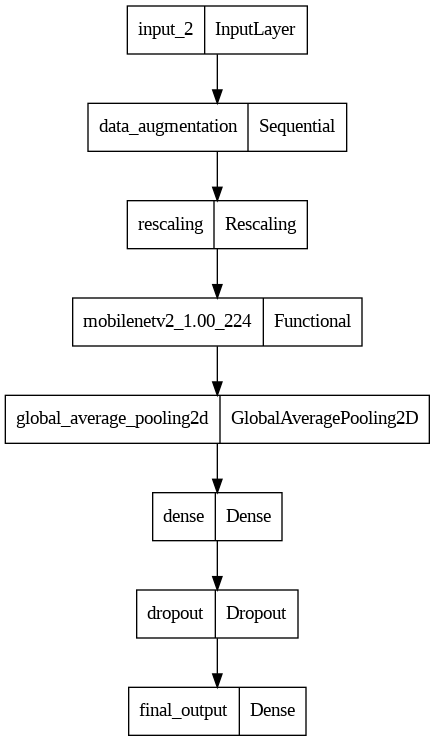

In [34]:
plot_model(model)

## **Define Callbacks**

In [35]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("checkpoint_model.h5",
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10,
                                                  mode ="max",
                                                  verbose=2,
                                                  restore_best_weights=True)

# **Model Training**

In [36]:
history = model.fit(train_ds,
                    epochs=100,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
388/388 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.8369
Epoch 1: val_accuracy improved from -inf to 0.91463, saving model to checkpoint_model.h5
388/388 [==============================] - 36s 58ms/step - loss: 0.5145 - accuracy: 0.8369 - val_loss: 0.2656 - val_accuracy: 0.9146
Epoch 2/100
387/388 [============================>.] - ETA: 0s - loss: 0.3457 - accuracy: 0.8851
Epoch 2: val_accuracy improved from 0.91463 to 0.92144, saving model to checkpoint_model.h5
388/388 [==============================] - 20s 52ms/step - loss: 0.3457 - accuracy: 0.8851 - val_loss: 0.2343 - val_accuracy: 0.9214
Epoch 3/100
387/388 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.9016
Epoch 3: val_accuracy did not improve from 0.92144
388/388 [==============================] - 20s 51ms/step - loss: 0.2952 - accuracy: 0.9015 - val_loss: 0.2434 - val_accuracy: 0.9186
Epoch 4/100
387/388 [============================>.] - ETA: 0s - loss: 0.2661 

# **Accuracy and Plot Lost Graph Model MobileNetV2**

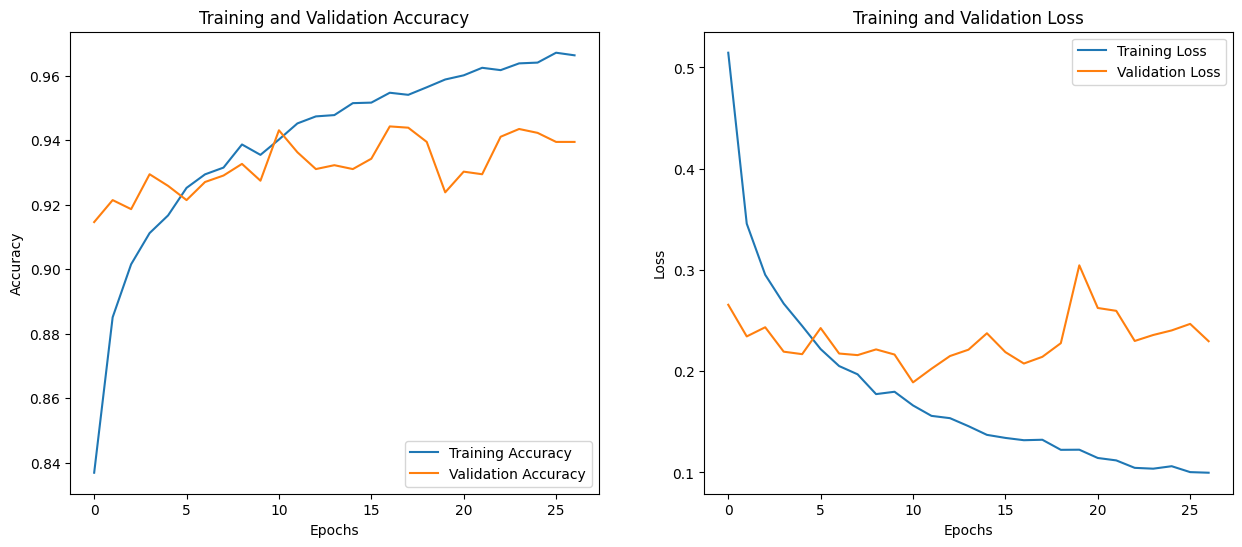

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Evaluating Model**

In [38]:
load_model = tf.keras.models.load_model('checkpoint_model.h5')
load_model.evaluate(x=test_dataset, return_dict=True)

19/19 [==============================] - 2s 43ms/step - loss: 0.2104 - accuracy: 0.9408


{'loss': 0.21041786670684814, 'accuracy': 0.9407894611358643}

# **Testing Model**

In [39]:
class_names = np.array(class_names)
class_names_val = np.array(class_names_val)

print(f'List label Train data: \n{class_names}\n')
print(f'List label Validation data: \n{class_names_val}')

image_batch_test, label_batch_test = next(iter(test_dataset))

image_batch_test, label_batch_test = image_batch_test.numpy(), label_batch_test.numpy()


predicted_batch = load_model.predict(image_batch_test)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

List label Train data: 
['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']

List label Validation data: 
['battery' 'biological' 'cardboard' 'clothes' 'glass' 'metal' 'paper'
 'plastic' 'shoes' 'trash']
1/1 [==============================] - 1s 776ms/step
['metal' 'plastic' 'glass' 'clothes' 'biological' 'clothes' 'glass'
 'shoes' 'clothes' 'clothes' 'biological' 'clothes' 'clothes' 'trash'
 'shoes' 'clothes' 'biological' 'metal' 'clothes' 'plastic' 'glass'
 'clothes' 'shoes' 'clothes' 'clothes' 'paper' 'clothes' 'glass' 'paper'
 'clothes' 'shoes' 'paper']


In [40]:
print(f"Labels:\n{label_batch_test}")
print(f"Predicted labels:\n{predicted_ids}")

true_predict = 0
false_predict = 0

for i in predicted_ids:
  if i in label_batch_test:
    true_predict +=1
  else:
    false_predict +=1

print()
print(f'True Predict Count : {true_predict}')
print(f'False Predict Count : {false_predict}')

Labels:
[5 7 4 3 1 3 4 8 3 3 1 3 3 9 8 3 1 5 3 7 4 3 8 3 3 6 3 4 6 3 8 6]
Predicted labels:
[5 7 4 3 1 3 4 8 3 3 1 3 3 9 8 3 1 5 3 7 4 3 8 3 3 6 3 4 6 3 8 6]

True Predict Count : 32
False Predict Count : 0


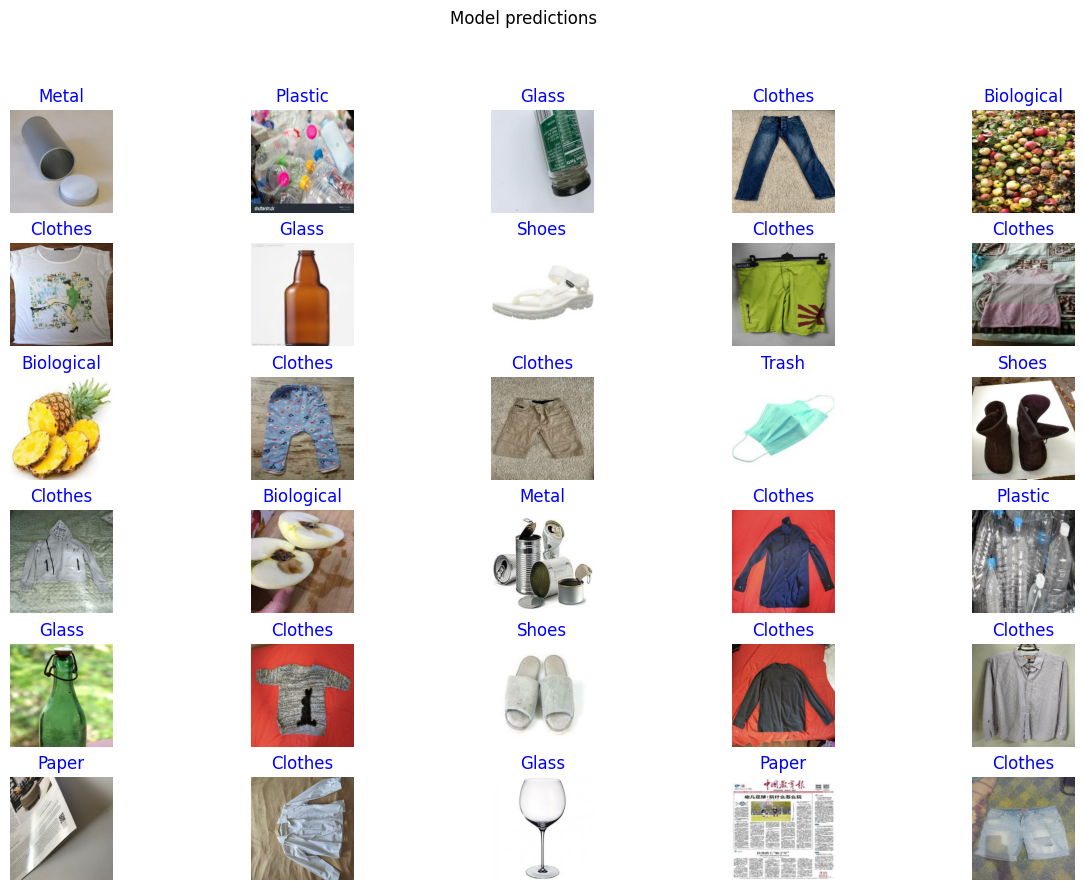

In [41]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n].astype('uint8'))
  color = "blue" if predicted_ids[n] == label_batch_test[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Mounted at /content/drive
1/1 [==============================] - 1s 1s/step


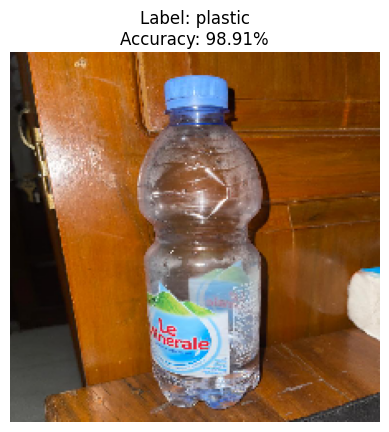

Detected class: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 23ms/step


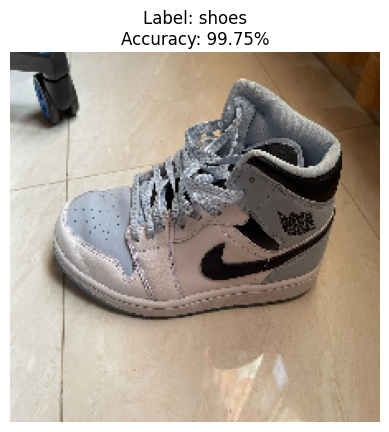

Detected class: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1/1 [==============================] - 0s 23ms/step


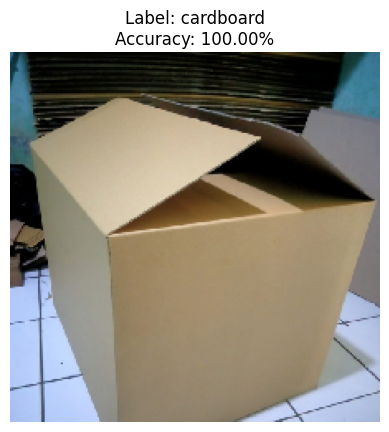

Detected class: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 22ms/step


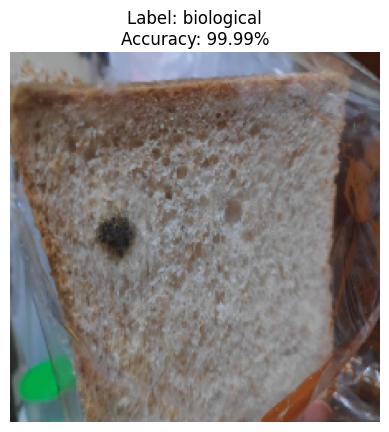

Detected class: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 24ms/step


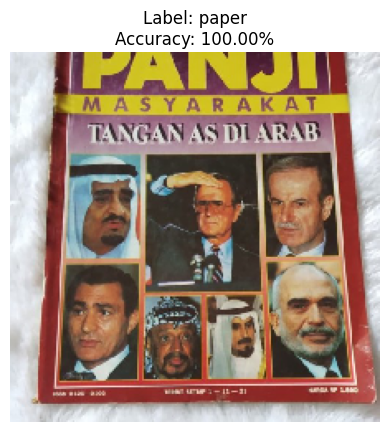

Detected class: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
1/1 [==============================] - 0s 23ms/step


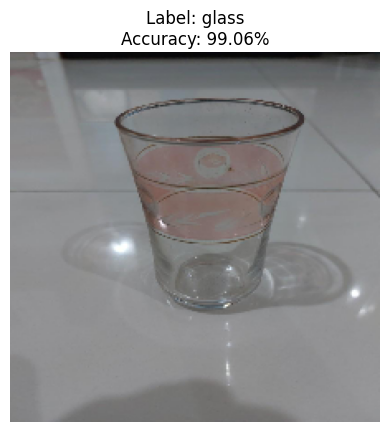

Detected class: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 22ms/step


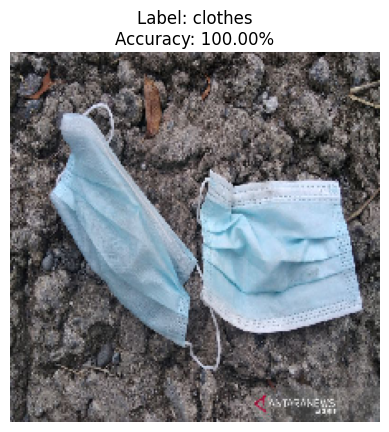

Detected class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 22ms/step


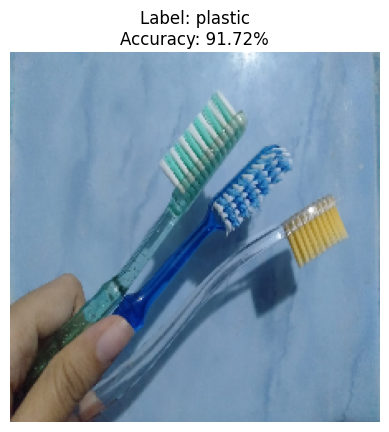

Detected class: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 23ms/step


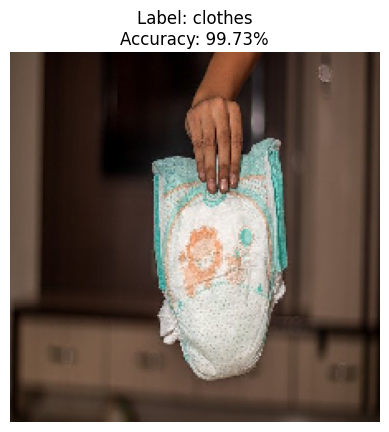

Detected class: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 21ms/step


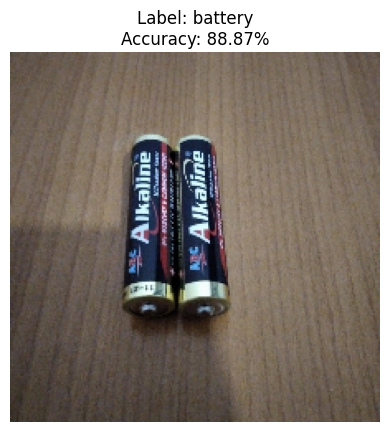

Detected class: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 21ms/step


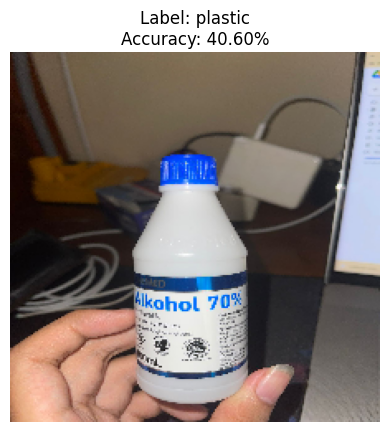

Detected class: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [42]:
from google.colab import drive
import keras.utils as image
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Specify the directory path in your Google Drive
dir_path = '/content/drive/MyDrive/Garbage_dataset/'

# Get all files in the directory
files = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

for file in files:
    img = image.load_img(join(dir_path, file), target_size=IMG_SIZE + (3,))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = load_model.predict(images, batch_size=10)
    outclass = np.argmax(classes)

    # Convert predicted class into one-hot encoded format
    one_hot_class = np.zeros_like(classes[0])
    one_hot_class[outclass] = 1

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: {class_names[outclass]}\nAccuracy: {classes[0][outclass]:.2%}')
    plt.show()

    print(f'Detected class: {one_hot_class}')

## **Testing with sklearn()**

In [43]:
x_test = []
y_test = []

for x_batch, y_batch in test_dataset:
  for x_i, y_i in zip(x_batch, y_batch):
    x_test.append(x_i)
    y_test.append(y_i)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [44]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

y_pred = np.argmax(model.predict(x_test), axis=-1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

19/19 [==============================] - 1s 40ms/step
Accuracy: 93.91%


In [45]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

class_names_test = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

print(classification_report(y_test, y_pred, target_names=class_names_test))

              precision    recall  f1-score   support

     battery       1.00      0.87      0.93        31
  biological       0.97      0.95      0.96        39
   cardboard       0.93      0.87      0.90        31
     clothes       0.98      0.99      0.98       217
       glass       0.96      0.86      0.91        81
       metal       0.73      0.97      0.84        37
       paper       0.86      1.00      0.93        32
     plastic       0.87      0.77      0.82        35
       shoes       0.94      0.96      0.95        71
       trash       1.00      0.94      0.97        34

    accuracy                           0.94       608
   macro avg       0.93      0.92      0.92       608
weighted avg       0.94      0.94      0.94       608



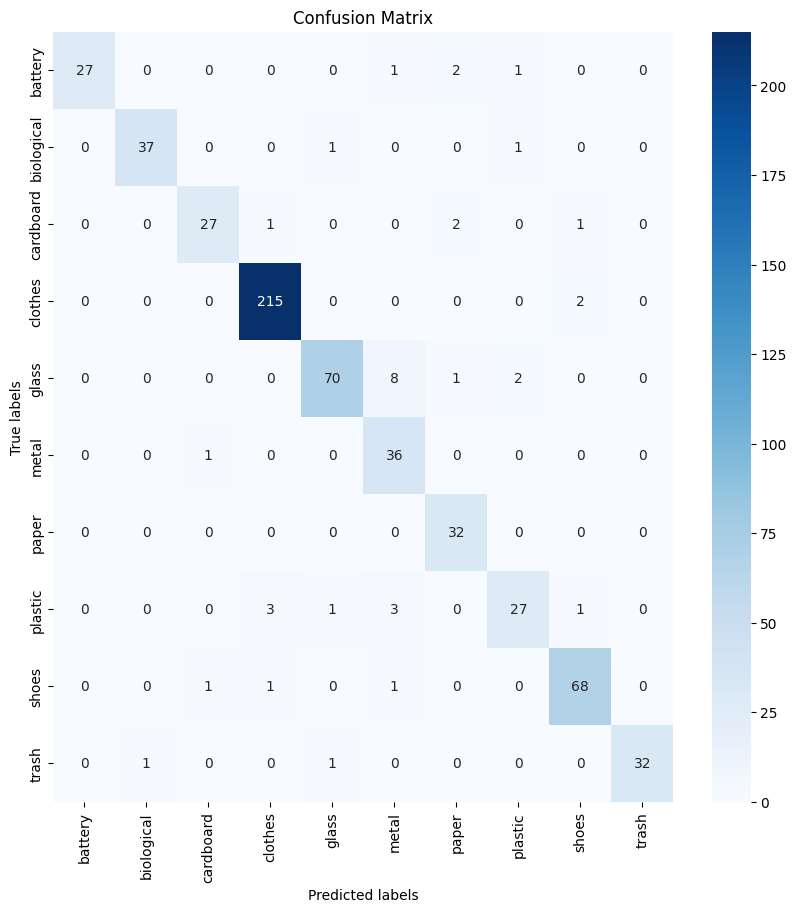

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## **ROC**

19/19 [==============================] - 1s 37ms/step


<ipython-input-47-e7ebc6fb580b>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


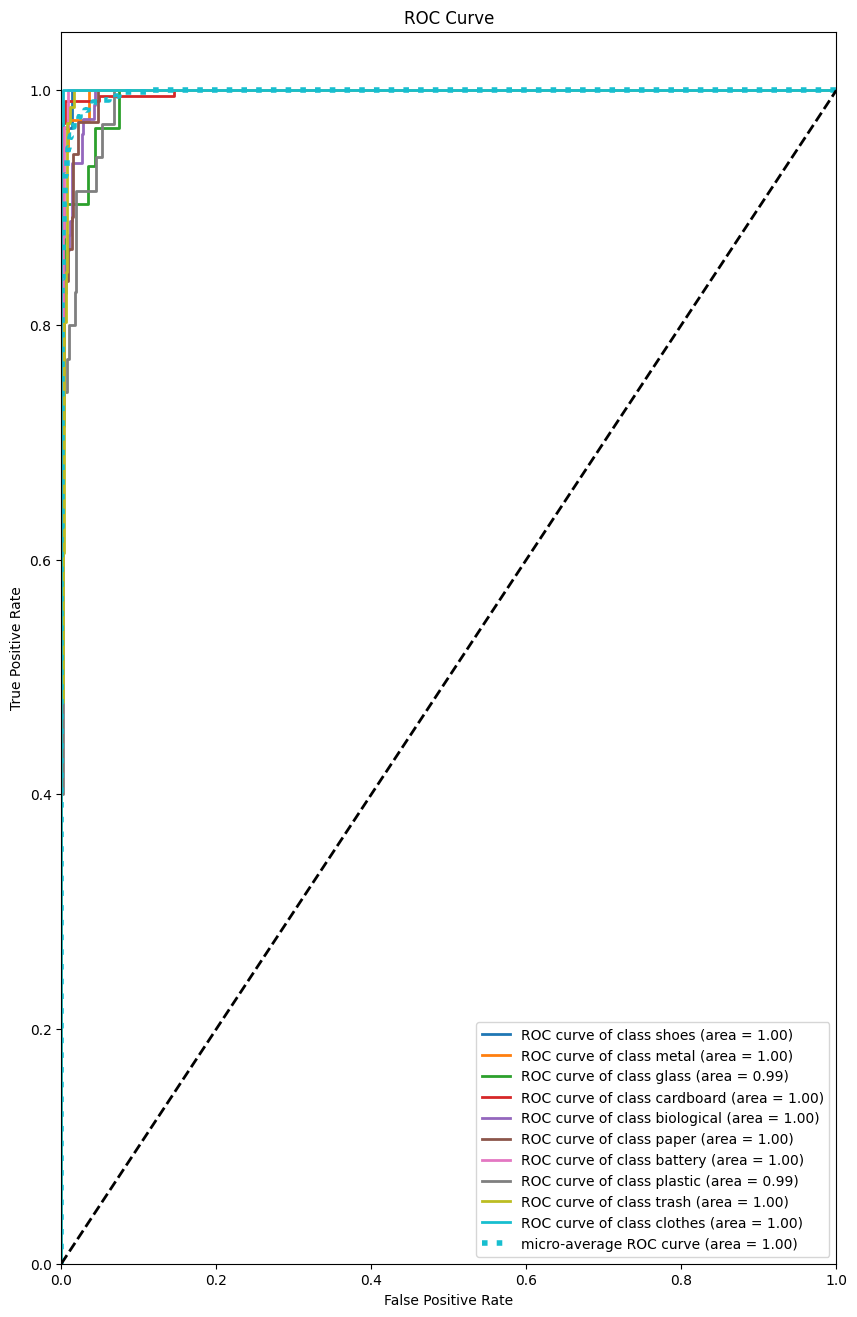

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm

n_classes = len(class_labels)
y_test = keras.utils.to_categorical(y_test, num_classes=n_classes)
y_pred = model.predict(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')

cmap = cm.get_cmap('tab10')

plt.figure(figsize=(10,16))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## **AUC**

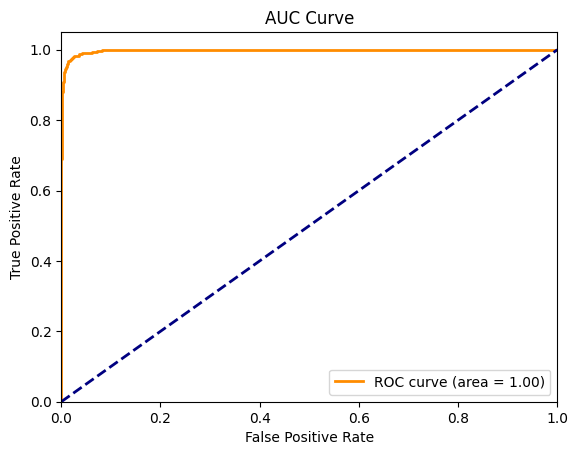

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming y_pred and y_test are numpy arrays
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr['micro'], tpr['micro'], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc['micro'])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right")
plt.show()

# **Convert Model to TF Js**

In [53]:
import tensorflowjs as tfjs

# Save the model
model.save('model')

# Convert the model to tensorflow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Archive the tensorflow.js model into a .zip file
shutil.make_archive('ModelMobileNet', 'zip', 'tfjs_model')

# Download the .zip file
files.download('ModelMobileNet.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Convert Model to TF Lite**

In [54]:
import tensorflow as tf
from google.colab import files

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a .tflite file
with open('ModelMobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

# Download the .tflite file
files.download('ModelMobileNet.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>